<h2>Importing Libraries</h2>

In [ ]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import f1_score

# <h2> Reading Data </h2>

In [ ]:
train = pd.read_csv('train_PDjVQMB.csv')
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [ ]:
train.shape

(6650, 11)

- The give data contains the customer demographics and past activity with the bank
because of this several questions arise,for example, the balance is for a specific day, what date is it, and what significance does this date have?
Is it possible to get balances over a period of time rather than just one date?

In [ ]:
test = pd.read_csv('test_lTY72QC.csv')
test.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average
1,9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average
2,a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good
3,b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
4,dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good


In [ ]:
test.shape

(2851, 10)

# <h2> Exploratory Data Analysis </h2>

In [ ]:
train["Is_Churn"].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [ ]:
target_instance = train["Is_Churn"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
fig = px.pie(target_instance, values='Is_Churn', names='Category', color_discrete_sequence=["green", "red"],
             title='Distribution of Churn')
fig.show()

We're attempting to forecast the number of customers who will abandon the bank in the following six months. With an uneven target, it's a binary classification problem.



<h2> Checking for missing values </h2>

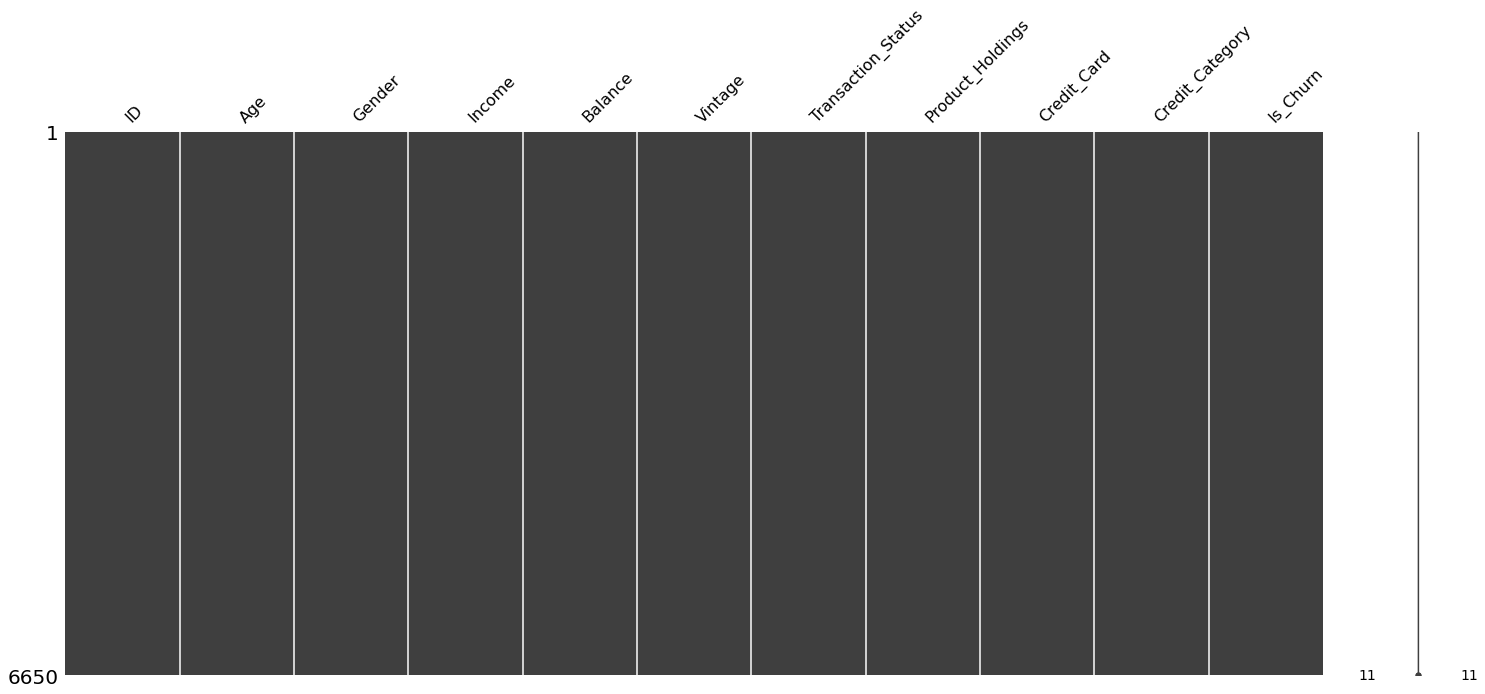

In [ ]:
mno.matrix(train)

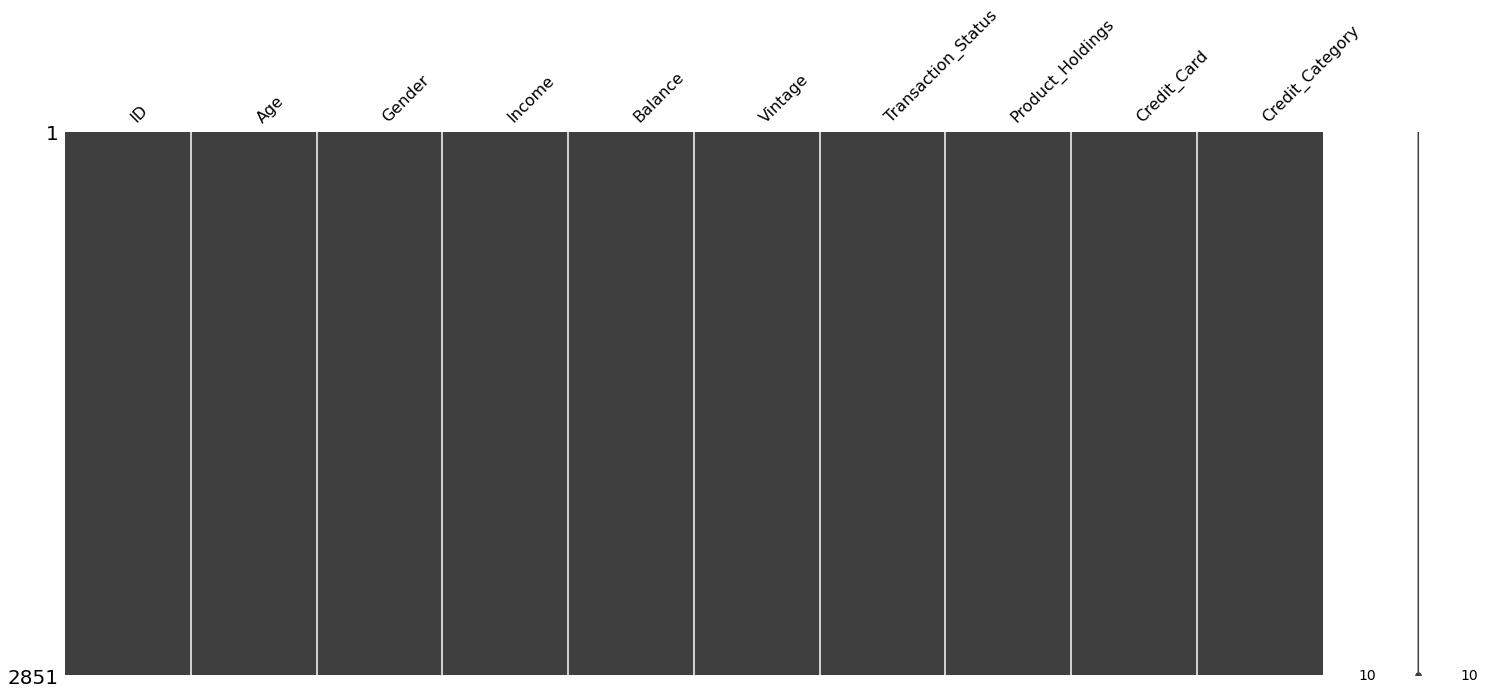

In [ ]:
mno.matrix(test)

There are no missing values present in our data set.

<h2> Descriptive Statistics </h2>

<h3>1. Train data</h3>

In [ ]:
train.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000



- The columns, Transaction_Status, Credit_Card, and Is_Churn have weird quartile values. Lets see min and max values of each column.

In [ ]:
print("The column Transaction Status has values {}".format((min(train['Transaction_Status']), max(train['Transaction_Status']))))

The column Transaction Status has values (0, 1)


In [ ]:
print("The column Credit Card has values {}".format((min(train['Credit_Card']), max(train['Credit_Card']))))

The column Credit Card has values (0, 1)


In [ ]:
print("The column Is Churn has values {}".format((min(train['Is_Churn']), max(train['Is_Churn']))))

The column Is Churn has values (0, 1)


Since the values are in range 0 and 1, we get such quartile values. Lets go ahead and see what else we can find.

In [ ]:
train.skew(numeric_only=True) 

Age                   0.555171
Balance               0.464460
Vintage               0.021421
Transaction_Status   -0.063204
Credit_Card          -0.696287
Is_Churn              1.275912
dtype: float64

Skew indicates whether the data is evenly distributed or not. A value greater than +1 tells us that the feature Is_Churn is positively skewed as it has value 1.27.

In [ ]:
train.describe(include='object')

,ID,Gender,Income,Product_Holdings,Credit_Category
count,6650,6650,6650,6650,6650
unique,6650,2,4,3,3
top,84e2fcc9,Male,10L - 15L,1,Poor
freq,1,3612,1885,3200,3076


- The share of Male customers is more than Female customers in our bank.
- There are four different ranges of income of our customers, with the top most range of income is 10L-15L.
- There are three number of product holdings a customer has. Many of the customers hold only 1 product.
- The credit category is divided into three parts. The highest share of credit card category belongs to Poor class.

**Lets find all the unique values of the categorical features**

In [ ]:
print("The Gender column had values:", train.Gender.unique())
print()
print("We have customers belonging to four different payscales, they are", train.Income.unique())
print()
print("The number of product holdings owned by customers are", train.Product_Holdings.unique())
print()
print("There are three different credit categories in our bank. They are", train.Credit_Category.unique())

The Gender column had values: ['Female' 'Male']

We have customers belonging to four different payscales, they are ['5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L']

The number of product holdings owned by customers are ['1' '2' '3+']

There are three different credit categories in our bank. They are ['Average' 'Poor' 'Good']


<h3> Test Data </h3>

In [ ]:
test.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card
count,2851.000000,2.851000e+03,2851.000000,2851.000000,2851.000000
mean,41.252192,8.098990e+05,2.220975,0.506840,0.668888
std,9.616756,5.252003e+05,1.489941,0.500041,0.470696
min,21.000000,1.503000e+03,0.000000,0.000000,0.000000
25%,34.000000,4.009684e+05,1.000000,0.000000,0.000000
50%,40.000000,7.659125e+05,2.000000,1.000000,1.000000
75%,47.000000,1.154238e+06,3.000000,1.000000,1.000000
max,72.000000,2.434834e+06,5.000000,1.000000,1.000000


Same as train data, the values of column Transaction Status and Cresit_Card has values in range (0,1) that's why the quartile values are the way they are.

In [ ]:
test.describe(include='object')

,ID,Gender,Income,Product_Holdings,Credit_Category
count,2851,2851,2851,2851,2851
unique,2851,2,4,3,3
top,55480787,Male,10L - 15L,2,Poor
freq,1,1545,844,1359,1270


- The share of Male customers is more than Female customers in our bank.
- There are four different ranges of income of our customers, with the top most range of income is 10L-15L.
- There are three number of product holdings a customer has. Many of the customers hold 2 products.
- The credit category is divided into three parts. The highest share of credit card category belongs to Poor class.

**Lets find all the unique values of the categorical features**

In [ ]:
print("The Gender column had values:", test.Gender.unique())
print()
print("We have customers belonging to four different payscales, they are", test.Income.unique())
print()
print("The number of product holdings owned by customers are", test.Product_Holdings.unique())
print()
print("There are three different credit categories in our bank. They are", test.Credit_Category.unique())

The Gender column had values: ['Female' 'Male']

We have customers belonging to four different payscales, they are ['More than 15L' '5L - 10L' '10L - 15L' 'Less than 5L']

The number of product holdings owned by customers are ['2' '3+' '1']

There are three different credit categories in our bank. They are ['Average' 'Good' 'Poor']


<h2> Verify presence of outliers </h2>

We will verify the precense of outliers in the data using Inter Quartile Range (IQR).

Rule : Data points that lie 1.5 times of IQR below Q1 and above Q3 are considered to be outliers.

In [ ]:
num_fea = [col for col in train.columns if train[col].dtype in ('int64', 'float64')]

def detect_outliers_iqr(data, num_features):
    outlier_value = []
    final_list = {}
    for i in num_features:
        data2 = data[i].values
        data2 = sorted(data2)           # sort in ascending order
        Q1 = np.percentile(data2, 25)     # first quartile
        Q3 = np.percentile(data2, 75)     # third quartile
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5*IQR)
        upper_bound = Q3 + (1.5*IQR)
        outlier_value = []
        for j in data2:
            if (j<lower_bound or j>upper_bound):
              outlier_value.append(j)
              final_list[i] = outlier_value
    return final_list
sample_outliers = detect_outliers_iqr(train, num_fea)
print("Features having outliers from IQR method: ", sample_outliers.keys())
print("\n Therefore total {} features have outliers present in them".format(len(sample_outliers.keys())))

Features having outliers from IQR method:  dict_keys(['Age', 'Balance', 'Is_Churn'])

 Therefore total 3 features have outliers present in them


In [ ]:
num_fea2 = [col for col in test.columns if test[col].dtype in ('int64', 'float64')]
sample_outliers2 = detect_outliers_iqr(test, num_fea2)
print("Features having outliers from IQR method: ", sample_outliers2.keys())
print("Therefore total {} features have outliers present in them".format(len(sample_outliers2.keys())))

Features having outliers from IQR method:  dict_keys(['Age', 'Balance'])
Therefore total 2 features have outliers present in them


We will further investigate the outliers to see if they are valid data points with respect to our data.

In [ ]:
print("The column Age has values in range {}".format((min(train['Age']), max(train['Age']))))
print()
print("The column Balance has values in range {}".format((min(train['Balance']), max(train['Balance']))))

The column Age has values in range (21, 72)

The column Balance has values in range (63.0, 2436615.81)


In [ ]:
len(sample_outliers['Age'])/train.shape[0] #train data outliers

0.008571428571428572

In [ ]:
len(sample_outliers['Balance'])/train.shape[0] #train data outliers

0.005714285714285714

In [ ]:
len(sample_outliers['Is_Churn'])/train.shape[0]

0.23112781954887218

In [ ]:
len(sample_outliers['Is_Churn'])

1537

In [ ]:
train['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

Seems as though our bank has less number of customers in having age range between 67-72, and Balance between 2280600.81 to 2436615.81, thats why they seem like outliers. We will keep these data points as they too provide value to our problem statement. If at all our metric suffers due to the presence of these outliers, we will then handle them.

However, as there is class imbalance, the class 1 is considered as an outlier by the IQR method. We will keep it is as it is too.

<h2> Review Is_Churn feature with some of the features 

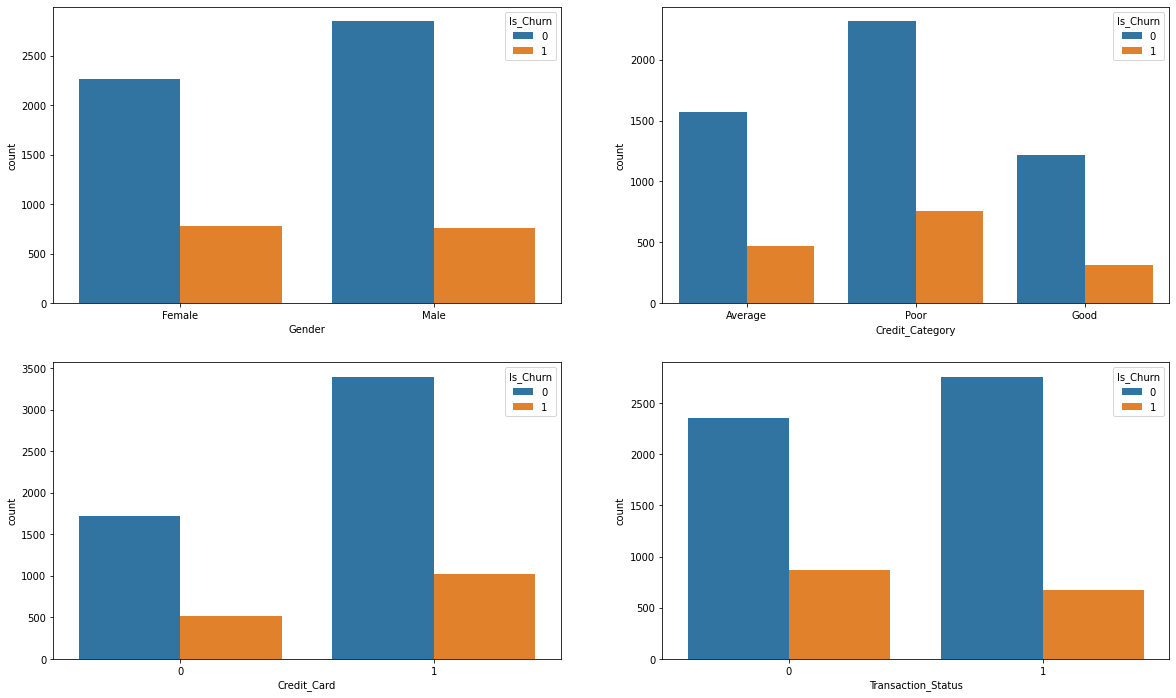

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Gender', hue = 'Is_Churn',data = train, ax=axarr[0][0])
sns.countplot(x='Credit_Category', hue = 'Is_Churn',data = train, ax=axarr[0][1])
sns.countplot(x='Credit_Card', hue = 'Is_Churn',data = train, ax=axarr[1][0])
sns.countplot(x='Transaction_Status', hue = 'Is_Churn',data = train, ax=axarr[1][1])

- The percentage of female customers who churn is the same as the percentage of male customers who churn.
- The customers belonging to Poor category are abandoning the bank more than other categories. Followed by Average and Good category customers.
- Surprisingly, credit card consumers make up the majority of churned customers. Given that the majority of clients use credit cards, this could just be a coincidence.
- Inactive members given by Transaction_Status, predictably, have a higher churn rate. 

<h2> Observing correlation </h2>

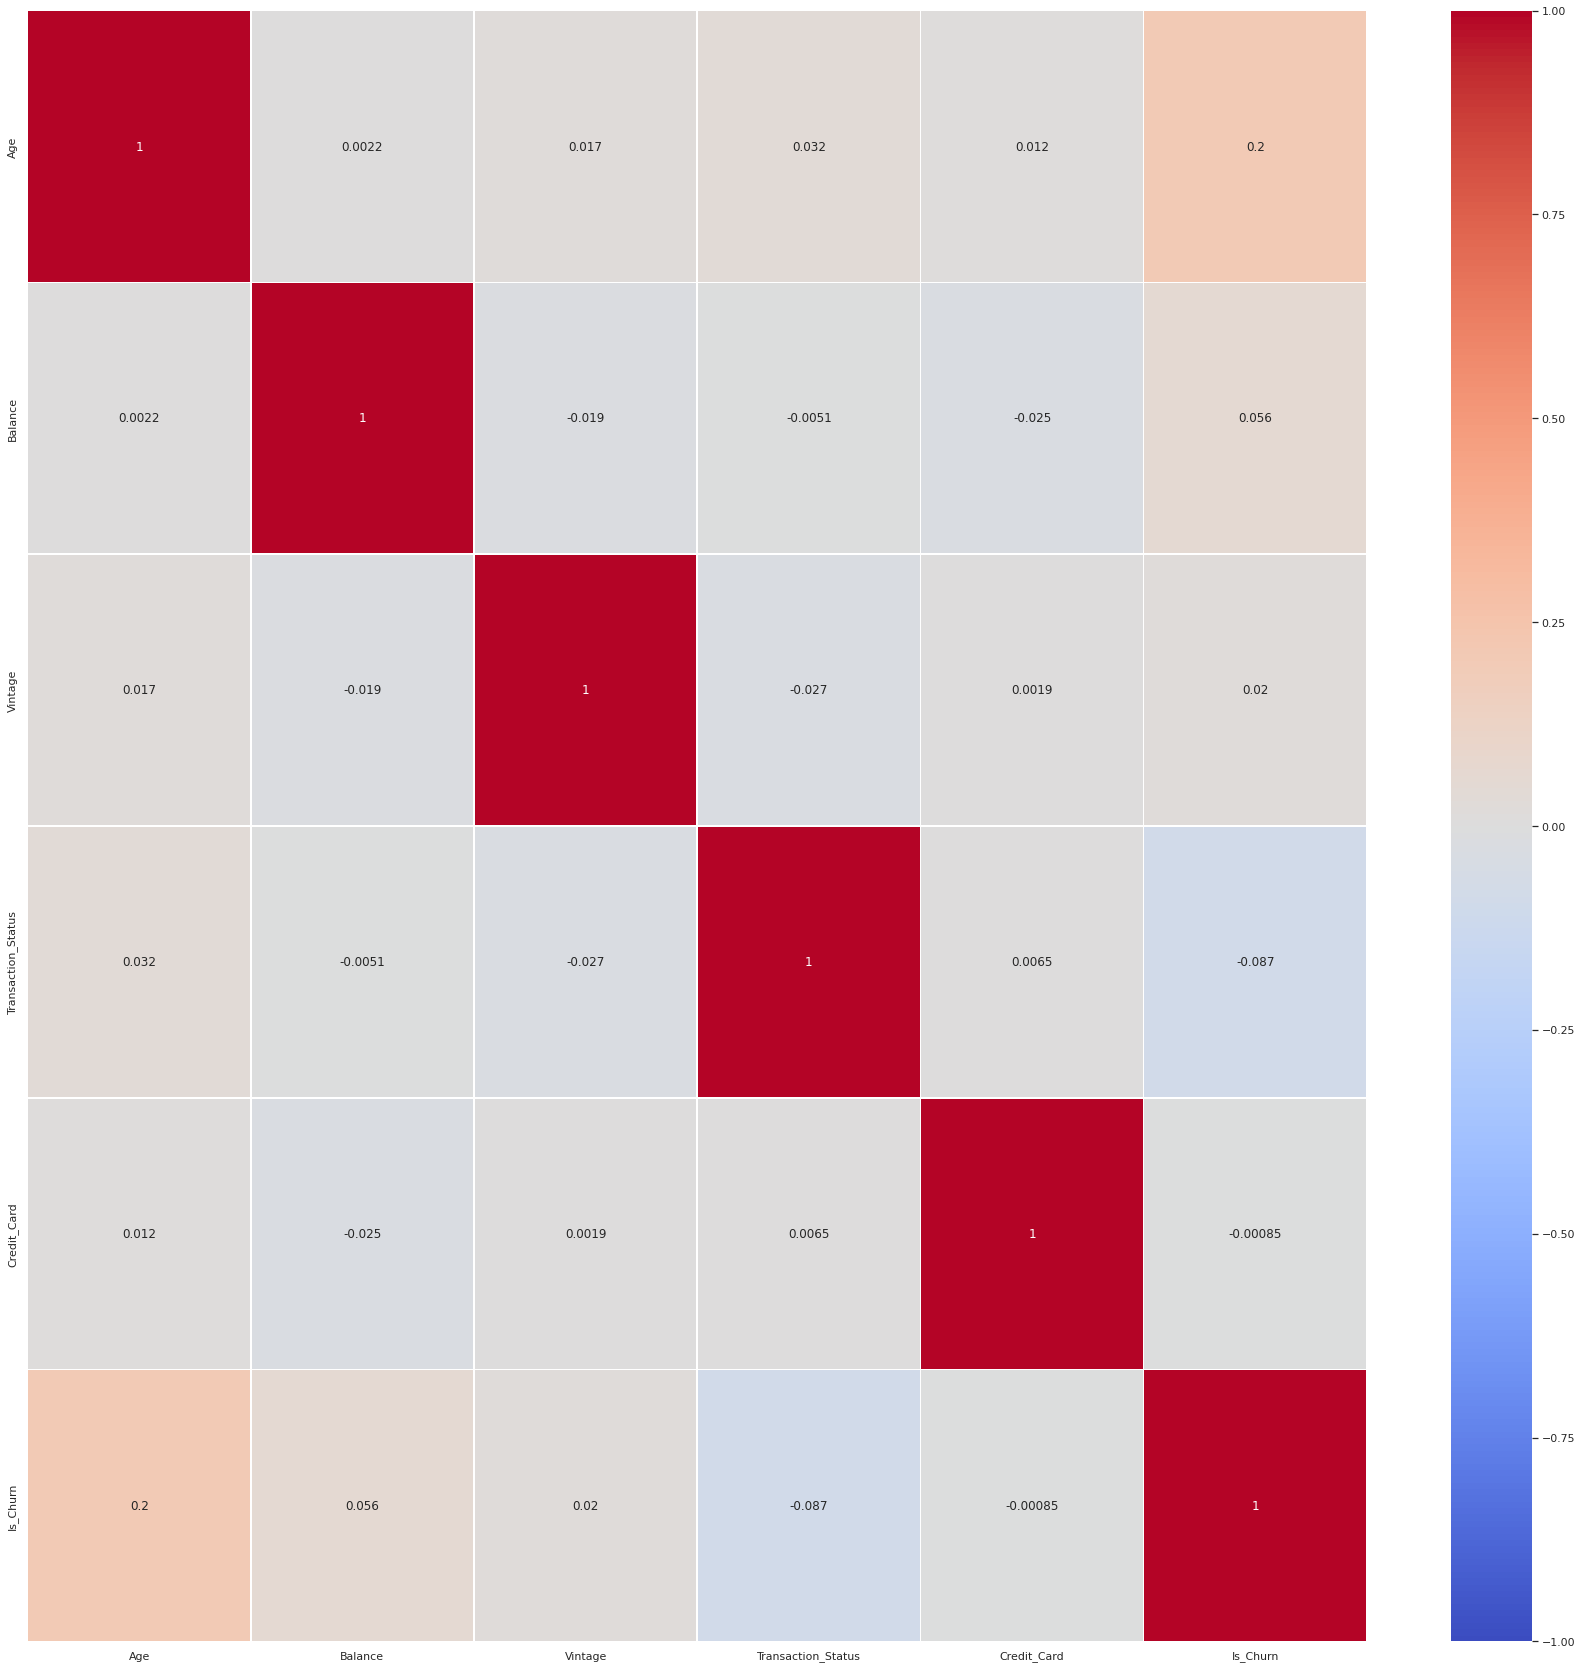

In [ ]:
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(train.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, ax=ax)

Features Age and Balance tends to hold a certain relation with our target variable. While for others, the data has poor correlation with our target variable.

Conclusion of EDA-

- There are outliers present in our data set as per the IQR method, although for now, we will keep them as it is.
- The feature Age and Balance has some correlation with our target variable, other than that, the features are not highly correlated with our target variable.
- Since features Age and Balance seem to be correlated with our target variable, this is yet another reason why keeping the outliers will be a right decision.
- Still after looking at the performance of our model, we will make a final call on this.

# <h2> Data Preprocessing </h2>

In [ ]:
def preprocess_categorical(df):
    Gender_map = {'Male': 1, 'Female': 0}
    Income_map = {'Less than 5L': 0, '5L - 10L': 1, '10L - 15L': 2, 'More than 15L': 3}
    Product_Holdings_map = {'1': 0, '2': 1, '3+': 2}
    Credit_Category_map = {'Poor': 0, 'Average': 1, 'Good': 2}
    conversions = [
        ('Gender', Gender_map, 'uint8'),
        ('Income', Income_map, 'uint8'),
        ('Credit_Category', Credit_Category_map, 'uint8'),
        ('Product_Holdings', Product_Holdings_map, 'uint8')
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
    return df

In [ ]:
train = preprocess_categorical(train)
test = preprocess_categorical(test)

<h3> Seperating target variable </h3>

In [ ]:
y = train['Is_Churn'].values
y.shape

(6650,)

In [ ]:
train.dtypes

ID                     object
Age                     int64
Gender                  uint8
Income                  uint8
Balance               float64
Vintage                 int64
Transaction_Status      int64
Product_Holdings        uint8
Credit_Card             int64
Credit_Category         uint8
Is_Churn                int64
dtype: object

<h2> Feature Engineering </h2>

In [ ]:
def new_feature(df):
  df['BalanceIncomeRatio'] = df.Balance/(df.Income+0.01)
  return df

In [ ]:
#Successive Aggregated featues
def successive_aggregates(df, field1, field2):
    t = df.groupby(['ID', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('ID')[field2].agg(['sum','mean', 'min', 'max'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u


In [ ]:
train = new_feature(train)
test = new_feature(test)

In [ ]:
Tradditional_fields = successive_aggregates(train, 'Product_Holdings', 'Balance')
Tradditional_fields = Tradditional_fields.merge(successive_aggregates(train, 'Credit_Category', 'Transaction_Status'))

Teadditional_fields = successive_aggregates(test, 'Product_Holdings', 'Balance')
Teadditional_fields = Teadditional_fields.merge(successive_aggregates(test, 'Credit_Category', 'Transaction_Status'))

In [ ]:
Tradditional_fields.shape

(6650, 9)

In [ ]:
Teadditional_fields.shape

(2851, 9)

In [ ]:
Tradditional_fields.isnull().sum()

ID                                         0
Product_Holdings_Balance_sum               0
Product_Holdings_Balance_mean              0
Product_Holdings_Balance_min               0
Product_Holdings_Balance_max               0
Credit_Category_Transaction_Status_sum     0
Credit_Category_Transaction_Status_mean    0
Credit_Category_Transaction_Status_min     0
Credit_Category_Transaction_Status_max     0
dtype: int64

In [ ]:
train = pd.merge(train, Tradditional_fields, on = 'ID', how = 'left')
test = pd.merge(test, Teadditional_fields, on = 'ID', how = 'left')

In [ ]:
train.shape

(6650, 20)

In [ ]:
train.columns

Index(['ID', 'Age', 'Gender', 'Income', 'Balance', 'Vintage',
       'Transaction_Status', 'Product_Holdings', 'Credit_Card',
       'Credit_Category', 'Is_Churn', 'BalanceIncomeRatio',
       'Product_Holdings_Balance_sum', 'Product_Holdings_Balance_mean',
       'Product_Holdings_Balance_min', 'Product_Holdings_Balance_max',
       'Credit_Category_Transaction_Status_sum',
       'Credit_Category_Transaction_Status_mean',
       'Credit_Category_Transaction_Status_min',
       'Credit_Category_Transaction_Status_max'],
      dtype='object')

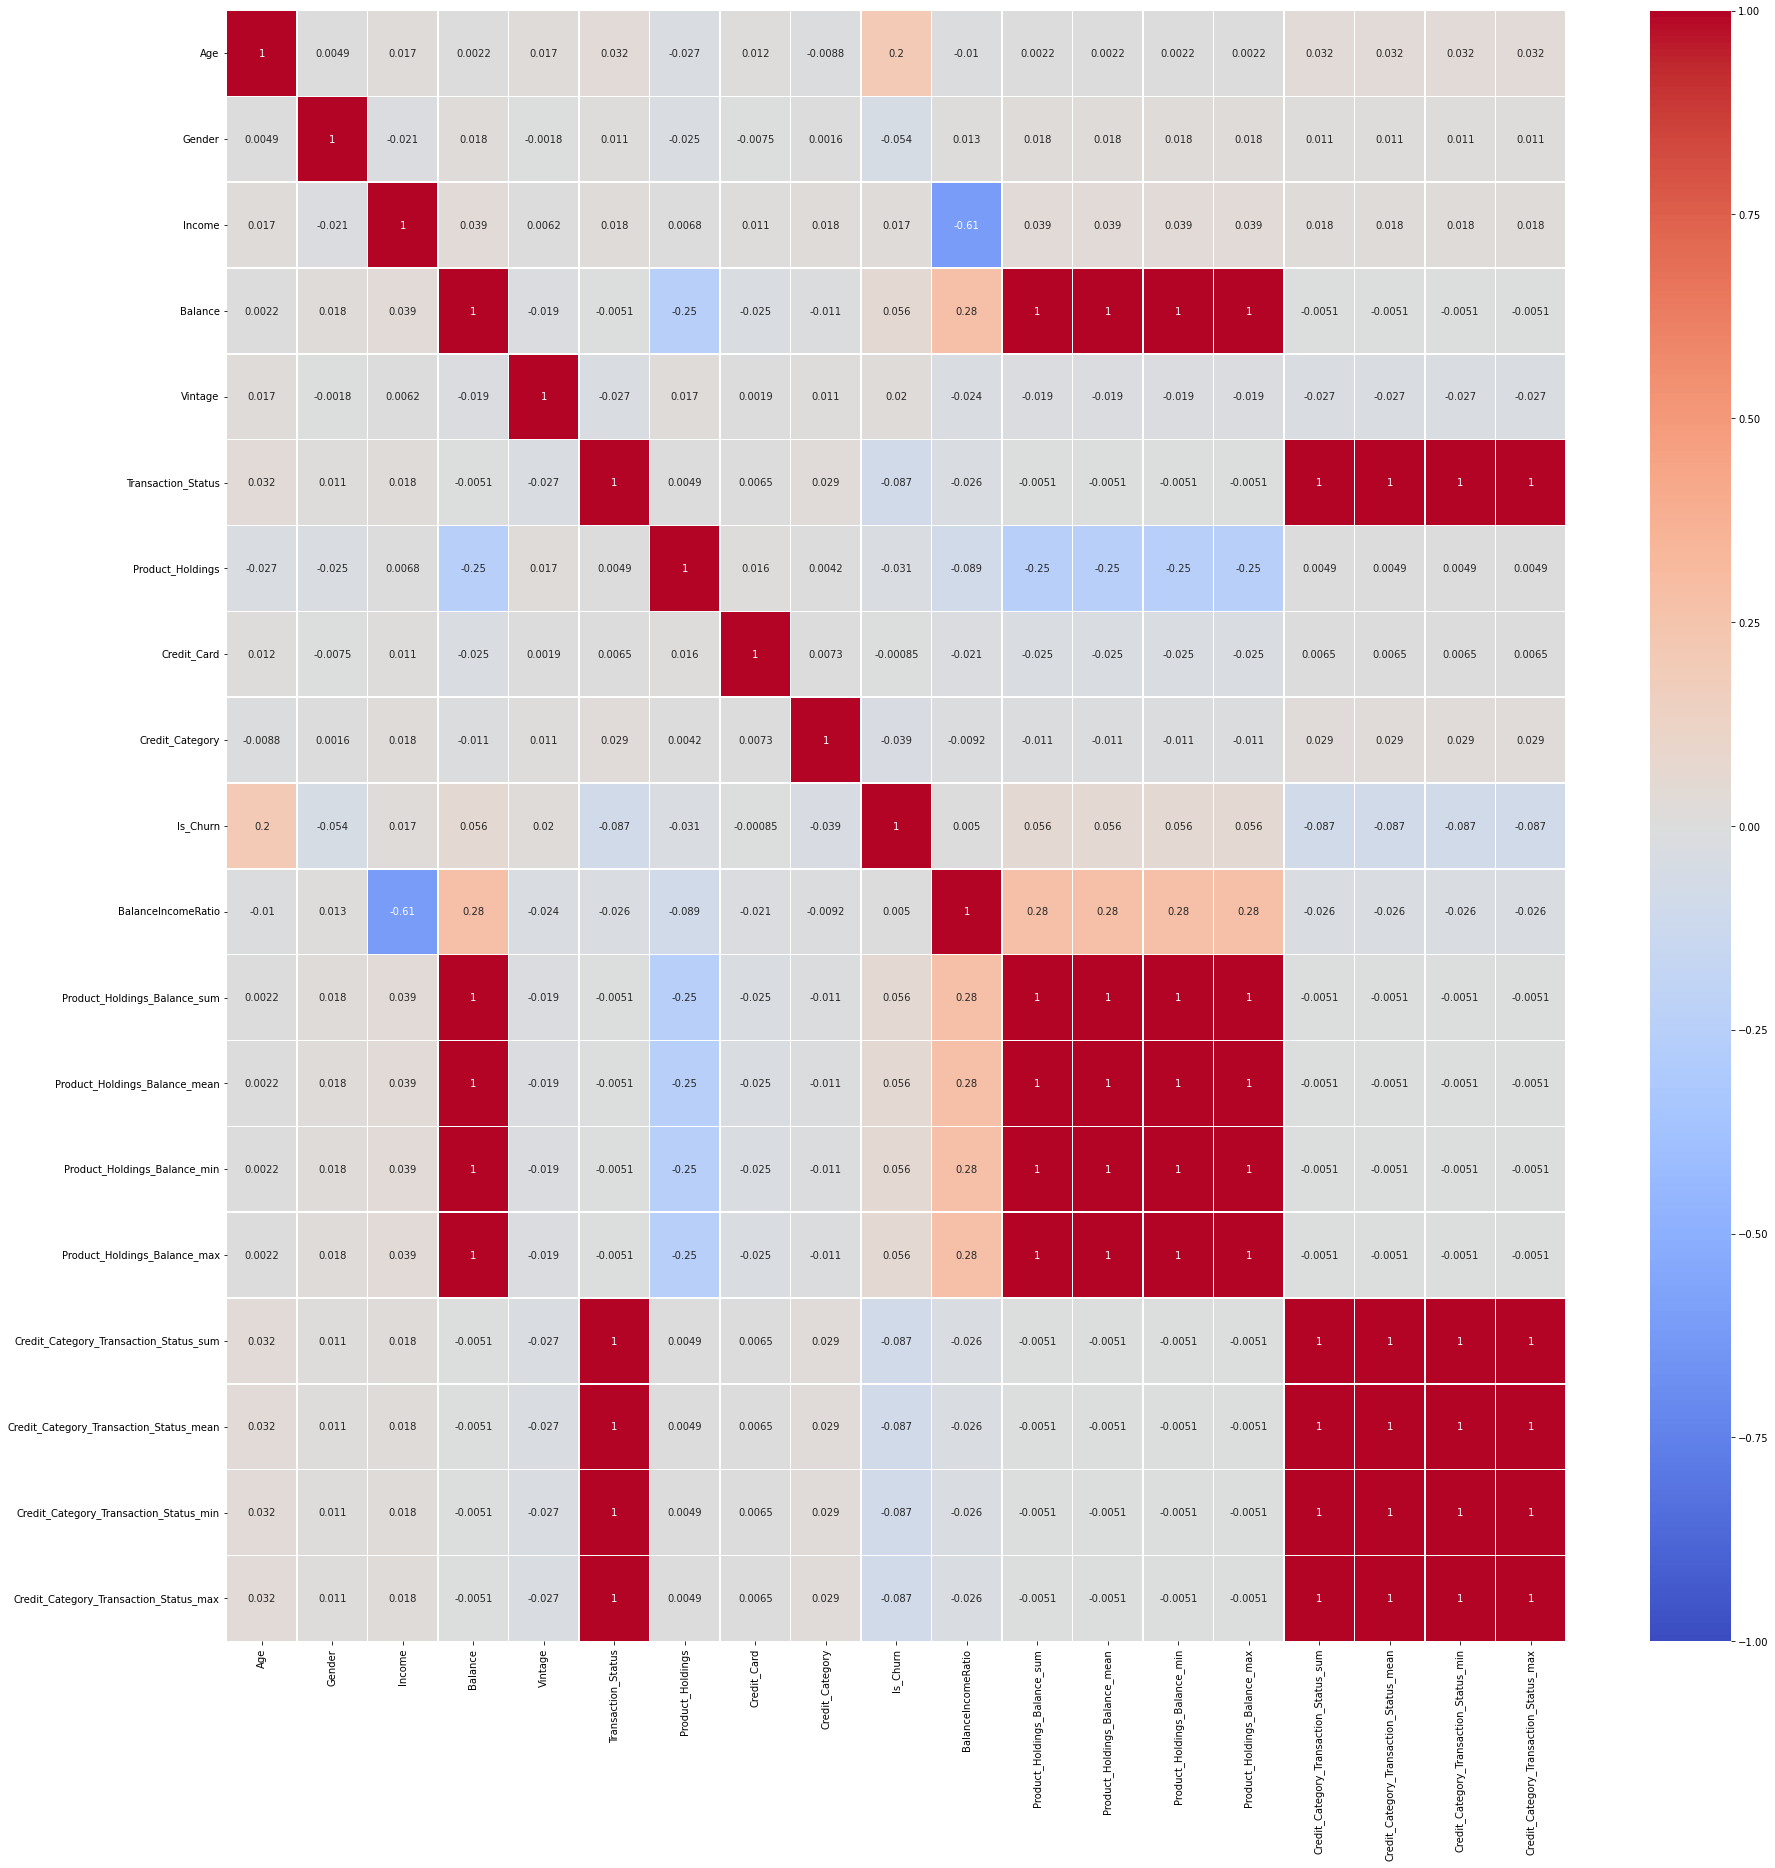

In [ ]:
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(train.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', linewidths=.5, ax=ax)

<h2> Normalizing numerical features </h2>

In [ ]:
train_ids = train['ID']
test_ids = test['ID']

In [ ]:
train = train.drop(['ID','Is_Churn'], axis = 1)
test = test.drop(['ID'], axis = 1)

# Up-Sampling to address class imbalance

In order to improve the score, we will try Up-Sampling our dataset's minority class

#<h2> Modelling on over sampled Data </h2>

I read the train and test data, performed all the steps before normalizing and came directly here.

In [ ]:
X_train.shape

(5320, 18)

<h2>1. Baseline Model : Logistic Regression </h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__solver' : ['lbfgs','newton-cg','liblinear','sag'], 'classifier__penalty': ['l2'], 'classifier__C': [100, 10, 1.0, 0.1, 0.01, 0.001], 'classifier__max_iter' : [100, 1000,2500, 5000]}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
#test_score = random_result.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.581110416669414
CPU times: user 1.48 s, sys: 290 ms, total: 1.77 s
Wall time: 17.2 s


In [ ]:
print(random_result.best_params_)

{'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__max_iter': 2500, 'classifier__C': 100}


In [ ]:
model = LogisticRegression(solver = 'lbfgs', penalty = 'l2', max_iter = 2500, C = 100)
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5113
           1       0.00      0.00      0.00      1537

    accuracy                           0.77      6650
   macro avg       0.38      0.50      0.43      6650
weighted avg       0.59      0.77      0.67      6650



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2> 2. Ridge Classifier </h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RidgeClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
#test_score = random_result.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.5828383255572496
CPU times: user 856 ms, sys: 99.1 ms, total: 955 ms
Wall time: 10.2 s


In [ ]:
print(random_result.best_params_)

{'classifier__alpha': 0.8}


In [ ]:
model = RidgeClassifier(alpha = 0.8)
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5113
           1       0.63      0.02      0.03      1537

    accuracy                           0.77      6650
   macro avg       0.70      0.51      0.45      6650
weighted avg       0.74      0.77      0.68      6650



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.09518e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


<h2> K Nearest Neighbor </h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', RobustScaler()],
                                ['classifier', KNeighborsClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__n_neighbors' : range(2, 21, 2), 'classifier__weights' : ['uniform', 'distance'],'classifier__metric' : ['euclidean', 'manhattan', 'minkowski']}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.545142334653657
CPU times: user 1.33 s, sys: 112 ms, total: 1.44 s
Wall time: 24.9 s


In [ ]:
print(random_result.best_params_)

{'classifier__weights': 'uniform', 'classifier__n_neighbors': 20, 'classifier__metric': 'minkowski'}


In [ ]:
model = KNeighborsClassifier(weights = 'uniform', n_neighbors = 20, metric = 'minkowski')
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5113
           1       0.33      0.00      0.00      1537

    accuracy                           0.77      6650
   macro avg       0.55      0.50      0.44      6650
weighted avg       0.67      0.77      0.67      6650



<h2> Support Vector Machine (SVM) </h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', RobustScaler()],
                                ['classifier', SVC()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__kernel': ['poly', 'rbf', 'sigmoid'], 'classifier__C': [50, 10, 1.0, 0.1, 0.01], 'classifier__gamma': ['scale']}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
#test_score = random_result.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.5792409510713331
CPU times: user 9.66 s, sys: 655 ms, total: 10.3 s
Wall time: 7min 49s


In [ ]:
print(random_result.best_params_)

{'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 50}


In [ ]:
model = SVC(kernel = 'rbf', gamma = 'scale', C = 50)
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      5113
           1       0.00      0.00      0.00      1537

    accuracy                           0.77      6650
   macro avg       0.38      0.50      0.43      6650
weighted avg       0.59      0.77      0.67      6650



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2> Random Forest</h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11, sampling_strategy = 'minority')],
                                ['scaler', RobustScaler()],
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__n_estimators': [10, 100, 1000], 'classifier__max_features': ['sqrt', 'log2'], 'classifier__max_depth': [2,5,8,15,20]}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
#test_score = random_result.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.5588330420952653
CPU times: user 2.31 s, sys: 365 ms, total: 2.67 s
Wall time: 2min 41s


In [ ]:
print(random_result.best_params_)

{'classifier__n_estimators': 10, 'classifier__max_features': 'log2', 'classifier__max_depth': 8}


In [ ]:
model = RandomForestClassifier(n_estimators = 10, max_features = 'log2', max_depth = 8)
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5113
           1       0.97      0.06      0.11      1537

    accuracy                           0.78      6650
   macro avg       0.87      0.53      0.49      6650
weighted avg       0.82      0.78      0.70      6650



<h2> Stochastic Gradient Boosting </h2>

In [ ]:
%%time
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', RobustScaler()],
                                ['classifier',GradientBoostingClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
params = {'classifier__n_estimators': [10, 100, 500, 1000], 'classifier__learning_rate': [0.001, 0.01, 0.1], 'classifier__max_depth': [2,5,8,15,20], 'classifier__subsample': [0.5, 0.7, 1.0]}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions = params, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)

random_result = random_search.fit(train, y)

cv_score = random_result.best_score_
#test_score = random_result.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}')

Cross-validation score: 0.5717588067294416
CPU times: user 28.6 s, sys: 1.33 s, total: 30 s
Wall time: 25min 18s


In [ ]:
print(random_result.best_params_)

{'classifier__subsample': 0.7, 'classifier__n_estimators': 1000, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.01}


In [ ]:
model = GradientBoostingClassifier(subsample = 0.7, n_estimators = 1000, max_depth = 2, learning_rate = 0.01)
model.fit(train, y)
print(classification_report(y,  model.predict(train)))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      5113
           1       0.69      0.06      0.11      1537

    accuracy                           0.78      6650
   macro avg       0.74      0.53      0.49      6650
weighted avg       0.76      0.78      0.70      6650



<h2> Ensemble: Voting Classifiers </h2>

In [ ]:
%%time
pipe =imbpipeline(steps = [('smote', SMOTE(random_state=11)),
                           ('scaler', RobustScaler()),
                           ('vc', VotingClassifier([('lr_classifier', LogisticRegression()),
                                                    ('gnb_classifier', GaussianNB()),
                                                    ('knn_classifier', KNeighborsClassifier()), 
                                                    ('svc_classifier', SVC(probability=True)),
                                                    ('random_classifier', RandomForestClassifier()), 
                                                    ('gb_classifier',GradientBoostingClassifier())], voting = 'soft'
                                                    )
                           )]
                  )

params = [{'vc__lr_classifier__solver' : ['lbfgs','newton-cg','liblinear','sag'], 'vc__lr_classifier__penalty': ['l2'], 'vc__lr_classifier__C': [100, 10, 1.0, 0.1, 0.01, 0.001], 'vc__lr_classifier__max_iter' : [100, 1000,2500, 5000]},
          {'vc__gnb_classifier__var_smoothing' : [1e-9]},
          {'vc__knn_classifier__n_neighbors' : range(2, 21, 2), 'vc__knn_classifier__weights' : ['uniform', 'distance'],'vc__knn_classifier__metric' : ['euclidean', 'manhattan', 'minkowski']},
          {'vc__svc_classifier__kernel': ['poly', 'rbf', 'sigmoid'], 'vc__svc_classifier__C': [50, 10, 1.0, 0.1, 0.01], 'vc__svc_classifier__gamma': ['scale']},
          {'vc__random_classifier__n_estimators': [10, 100, 1000], 'vc__random_classifier__max_features': ['sqrt', 'log2'], 'vc__random_classifier__max_depth': [2,5,8,15,20]},
          {'vc__gb_classifier__n_estimators': [10, 100, 500, 1000], 'vc__gb_classifier__learning_rate': [0.001, 0.01, 0.1], 'vc__gb_classifier__max_depth': [2,5,8,15,20], 'vc__gb_classifier__subsample': [0.5, 0.7, 1.0]}
         ]

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

random_search = RandomizedSearchCV(estimator=pipe, param_distributions = params, return_train_score = True, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)
random_search.fit(train, y)
y_pred = random_search.predict(test)

CPU times: user 1min 19s, sys: 5.19 s, total: 1min 24s
Wall time: 1h 15min 56s


In [ ]:
print(classification_report(y,  random_search.predict(train)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5113
           1       0.55      0.59      0.57      1537

    accuracy                           0.79      6650
   macro avg       0.71      0.72      0.72      6650
weighted avg       0.80      0.79      0.80      6650



The best macro F1 score is given by majority voting classifiers. Therefore, I'll be using it on final test data.

<h2> Testing performance of Voting Classifier on test data </h2>

In [ ]:
%%time
pipe =imbpipeline(steps = [('smote', SMOTE(random_state=11)),
                           ('scaler', RobustScaler()),
                           ('vc', VotingClassifier([('lr_classifier', LogisticRegression()),
                                                    ('gnb_classifier', GaussianNB()),
                                                    ('knn_classifier', KNeighborsClassifier()), 
                                                    ('svc_classifier', SVC(probability=True)),
                                                    ('random_classifier', RandomForestClassifier()), 
                                                    ('gb_classifier',GradientBoostingClassifier())], voting = 'soft'
                                                    )
                           )]
                  )

params = [{'vc__lr_classifier__solver' : ['lbfgs','newton-cg','liblinear','sag'], 'vc__lr_classifier__penalty': ['l2'], 'vc__lr_classifier__C': [100, 10, 1.0, 0.1, 0.01, 0.001], 'vc__lr_classifier__max_iter' : [100, 1000,2500, 5000]},
          {'vc__gnb_classifier__var_smoothing' : [1e-9]},
          {'vc__knn_classifier__n_neighbors' : range(2, 21, 2), 'vc__knn_classifier__weights' : ['uniform', 'distance'],'vc__knn_classifier__metric' : ['euclidean', 'manhattan', 'minkowski']},
          {'vc__svc_classifier__kernel': ['poly', 'rbf', 'sigmoid'], 'vc__svc_classifier__C': [50, 10, 1.0, 0.1, 0.01], 'vc__svc_classifier__gamma': ['scale']},
          {'vc__random_classifier__n_estimators': [10, 100, 1000], 'vc__random_classifier__max_features': ['sqrt', 'log2'], 'vc__random_classifier__max_depth': [2,5,8,15,20]},
          {'vc__gb_classifier__n_estimators': [10, 100, 500, 1000], 'vc__gb_classifier__learning_rate': [0.001, 0.01, 0.1], 'vc__gb_classifier__max_depth': [2,5,8,15,20], 'vc__gb_classifier__subsample': [0.5, 0.7, 1.0]}
         ]

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

random_search = RandomizedSearchCV(estimator=pipe, param_distributions = params, return_train_score = True, n_jobs = -1, cv = stratified_kfold, scoring='f1_macro', error_score=0)
random_search.fit(train, y)
y_pred = random_search.predict(test)

CPU times: user 1min 19s, sys: 5.19 s, total: 1min 24s
Wall time: 1h 15min 56s


In [ ]:
submission = pd.DataFrame()
submission['ID'] = test_ids
submission['Is_Churn'] = y_pred

In [ ]:
print(classification_report(y,  random_search.predict(train)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5113
           1       0.55      0.59      0.57      1537

    accuracy                           0.79      6650
   macro avg       0.71      0.72      0.72      6650
weighted avg       0.80      0.79      0.80      6650



In [ ]:
submission.shape

(2851, 2)

In [ ]:
submission.to_csv('stacked_churn_submission.csv', index=False)